In [31]:
import pandas as pd
import skimage
from skimage.transform import resize
from skimage.io import imread
from skimage.restoration import denoise_tv_bregman
from skimage.util import random_noise
from scipy import ndimage as nd
import numpy as np
import os
import matplotlib.pyplot as plt
import random

In [32]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models

In [34]:
Categories=['COVID','Normal']
Input_arr=[]
Target_arr=[]
datadir='C:\ML Algos\COVID-19_Radiography_Dataset'
for i in Categories:
  print(f'Loading...Category:{i}')
  path=os.path.join(datadir,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(100,100,3))
    denoised_img = denoise_tv_bregman(img_resized, weight=5.0, max_num_iter=100, eps=0.001, isotropic=True, channel_axis=-1)
    Input_arr.append(denoised_img.flatten())
    Target_arr.append(Categories.index(i))
  print(f'Loaded Category: {i} successfully')
input_data=np.array(Input_arr)
target_data=np.array(Target_arr)
df=pd.DataFrame(input_data)
df['Target']=target_data
X=df.iloc[:,:-1] 
y=df.iloc[:,-1]
X = X.to_numpy() 
y = y.to_numpy()

Loading...Category:COVID
Loaded Category: COVID successfully
Loading...Category:Normal
Loaded Category: Normal successfully


In [35]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)

In [36]:
X_train.size

331380000

In [37]:
X_train = X_train.reshape(len(X_train), 100, 100, 3)
y_train = y_train.reshape(len(y_train), 1)
X_test = X_test.reshape(len(X_test), 100, 100, 3)
y_test = y_test.reshape(len(y_test), 1)

In [38]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test: ",y_test.shape)

Shape of X_train:  (11046, 100, 100, 3)
Shape of X_test:  (2762, 100, 100, 3)
Shape of y_train:  (11046, 1)
Shape of y_test:  (2762, 1)


In [39]:
X_train[1,:]

array([[[ 2.06556647e-02,  2.08713696e-02,  2.08729092e-02],
        [ 3.12092986e-02,  3.13882554e-02,  3.13898436e-02],
        [ 8.13067458e-02,  8.09000322e-02,  8.09047075e-02],
        ...,
        [ 4.96467395e-02,  4.99251237e-02,  4.99252703e-02],
        [ 1.76731255e-02,  1.75453540e-02,  1.75447801e-02],
        [ 6.47140971e-03,  6.44102350e-03,  6.44073007e-03]],

       [[ 2.24186198e-02,  2.25913758e-02,  2.25934661e-02],
        [ 3.49981606e-02,  3.51443491e-02,  3.51473167e-02],
        [ 7.80863727e-02,  7.74794343e-02,  7.74874760e-02],
        ...,
        [ 5.12860368e-02,  5.16976537e-02,  5.16977892e-02],
        [ 2.03155860e-02,  2.02172465e-02,  2.02165320e-02],
        [ 7.60386586e-03,  7.58794567e-03,  7.58759256e-03]],

       [[ 2.15457658e-02,  2.17317975e-02,  2.17345684e-02],
        [ 3.35976141e-02,  3.37605006e-02,  3.37644100e-02],
        [ 7.12542433e-02,  7.06897744e-02,  7.06992051e-02],
        ...,
        [ 5.07384792e-02,  5.12160912e-02,

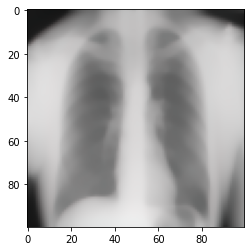

In [40]:
idx = random.randint(0,len(X_train))
plt.imshow(X_train[idx,:])
plt.show()

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LayerNormalization, Dropout
model = Sequential([
    Conv2D(filters = 15, kernel_size = (6,6), activation = 'relu', input_shape = (100, 100, 3), data_format = "channels_last"  ),
    LayerNormalization(axis=3 , center=True , scale=True),
    MaxPooling2D(4,4),
    

    Conv2D(filters = 15, kernel_size = (4,4), activation = 'relu', data_format = "channels_last" ),
    LayerNormalization(axis=3 , center=True , scale=True),
    MaxPooling2D(2,2),
    

    Flatten(),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')                
]) 
model.summary()
#Conv2D(No.OfFilters, Filter_Size, Filter_function, ExpectedImageShape);MaxPooling2D(Filter_Size);Dense(No.OfFullyConnectedNeurons,ActivationFunction)
#2 Layer CNN
#Final dense layer will the same number of neurons as the number of output classes except in binary classification

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 95, 95, 15)        1635      
                                                                 
 layer_normalization_2 (Laye  (None, 95, 95, 15)       30        
 rNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 15)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 15)        3615      
                                                                 
 layer_normalization_3 (Laye  (None, 20, 20, 15)       30        
 rNormalization)                                                 
                                                      

In [47]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [48]:
ConvNeuNet = model.fit(X_train, y_train, batch_size = 50, epochs = 75 , verbose=1, validation_data=(X_test, y_test))

Epoch 1/75
221/221 [==============================] - 56s 252ms/step - loss: 0.5690 - accuracy: 0.7357 - val_loss: 0.5401 - val_accuracy: 0.7451
Epoch 2/75
221/221 [==============================] - 54s 246ms/step - loss: 0.5240 - accuracy: 0.7452 - val_loss: 0.5047 - val_accuracy: 0.7455
Epoch 3/75
221/221 [==============================] - 52s 236ms/step - loss: 0.4777 - accuracy: 0.7804 - val_loss: 0.4594 - val_accuracy: 0.8020
Epoch 4/75
221/221 [==============================] - 51s 232ms/step - loss: 0.4564 - accuracy: 0.7934 - val_loss: 0.4333 - val_accuracy: 0.7915
Epoch 5/75
221/221 [==============================] - 52s 235ms/step - loss: 0.4433 - accuracy: 0.7982 - val_loss: 0.4232 - val_accuracy: 0.8117
Epoch 6/75
221/221 [==============================] - 50s 225ms/step - loss: 0.4313 - accuracy: 0.8035 - val_loss: 0.4084 - val_accuracy: 0.8088
Epoch 7/75
221/221 [==============================] - 46s 209ms/step - loss: 0.4203 - accuracy: 0.8089 - val_loss: 0.4113 - val_ac

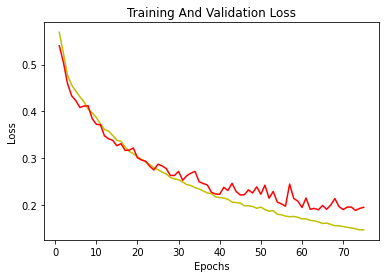

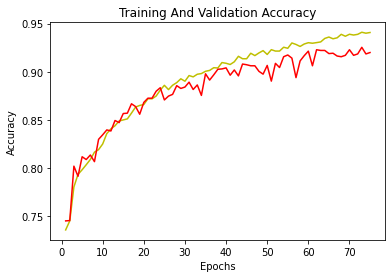

In [49]:
loss = ConvNeuNet.history['loss']
val_loss = ConvNeuNet.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

acc = ConvNeuNet.history['accuracy']
val_acc = ConvNeuNet.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Training Accuracy')
plt.title('Training And Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [50]:
ConvNeuNet.history

{'loss': [0.5689924359321594,
  0.5239975452423096,
  0.47769758105278015,
  0.456443190574646,
  0.44330090284347534,
  0.4313385784626007,
  0.42030441761016846,
  0.404924213886261,
  0.3966267704963684,
  0.3868010938167572,
  0.3735498785972595,
  0.36155617237091064,
  0.3577425479888916,
  0.34854477643966675,
  0.3385058641433716,
  0.3359858989715576,
  0.3237780034542084,
  0.314681738615036,
  0.30959352850914,
  0.30311235785484314,
  0.2975524663925171,
  0.2917669117450714,
  0.2862599194049835,
  0.27987462282180786,
  0.27549833059310913,
  0.2702353894710541,
  0.26628175377845764,
  0.2588810622692108,
  0.2557986080646515,
  0.2539791762828827,
  0.24923278391361237,
  0.24360564351081848,
  0.24168966710567474,
  0.23701895773410797,
  0.2343553900718689,
  0.2299903929233551,
  0.22578249871730804,
  0.22429078817367554,
  0.21738722920417786,
  0.2158808708190918,
  0.21492473781108856,
  0.2121341973543167,
  0.20630769431591034,
  0.20519571006298065,
  0.204216

In [51]:
model.evaluate(X_test,y_test)

87/87 [==============================] - 4s 42ms/step - loss: 0.1952 - accuracy: 0.9200


[0.19517536461353302, 0.9199855327606201]

In [52]:
y_pred = model.predict(X_test).reshape(-1,)
y_pred

87/87 [==============================] - 6s 42ms/step


array([0.03821323, 0.99575204, 0.9955416 , ..., 0.9998832 , 0.9904384 ,
       0.09816237], dtype=float32)

In [53]:
y_test

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [54]:
y_test = y_test.reshape(-1,)
y_test

array([0, 1, 1, ..., 1, 1, 0])

In [55]:
def plot_sample(X , y, index):
    plt.figure(figsize = (5,5))
    plt.imshow(X[index])
    plt.xlabel(Categories[y[index]])

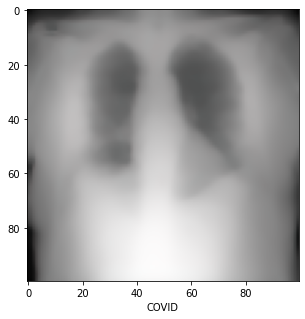

In [56]:
plot_sample(X_test, y_test, 650)

In [57]:
img = X_test[900]
inp_img = np.expand_dims(img, axis=0)
print(model.predict(inp_img))
print(y_test[900])

1/1 [==============================] - 0s 18ms/step
[[0.4982712]]
1


In [58]:
y_pred

array([0.03821323, 0.99575204, 0.9955416 , ..., 0.9998832 , 0.9904384 ,
       0.09816237], dtype=float32)

In [59]:
y_predclasses = [np.max(element) for element in y_pred]
for i in range(0,len(y_predclasses)):
    if y_predclasses[i] < 0.5:
       y_predclasses[i] = 0
    else:
       y_predclasses[i] = 1
y_predclasses

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [60]:
Categories[y_predclasses[2508]]

'Normal'

In [61]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print("Classification Report:\n",classification_report(y_test,y_predclasses))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_predclasses))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84       706
           1       0.94      0.95      0.95      2056

    accuracy                           0.92      2762
   macro avg       0.90      0.89      0.89      2762
weighted avg       0.92      0.92      0.92      2762

Confusion Matrix:
 [[ 590  116]
 [ 105 1951]]


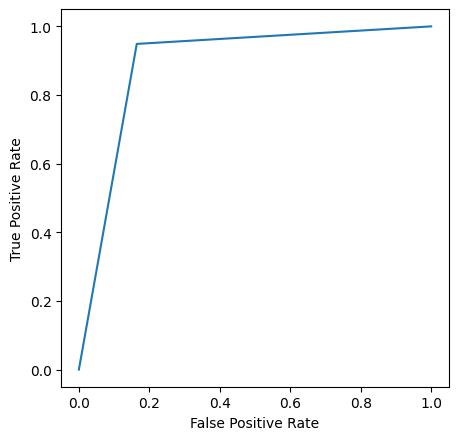

In [62]:
from sklearn.metrics import roc_curve,auc
FPR,TPR,threshold=roc_curve(y_test,y_predclasses)
auc = auc(FPR,TPR)
plt.figure(figsize=(5,5),dpi=100)
plt.plot(FPR,TPR,linestyle='-',label='SVM(auc=%0.3f)'%auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [63]:
#K-Fold Cross Validation
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5)

In [65]:
scores = []
for train_index, test_index in kf.split(X,y):
    X_train , y_train , X_test, y_test = X[train_index] , y[train_index] , X[test_index], y[test_index]
    X_train = X_train.reshape(len(X_train), 100, 100, 3)
    y_train = y_train.reshape(len(y_train), 1)
    X_test = X_test.reshape(len(X_test), 100, 100, 3)
    y_test = y_test.reshape(len(y_test), 1)
    model.fit(X_train, y_train, batch_size = 60, epochs = 5)
    scores.append(model.evaluate(X_test,y_test))
scores

Epoch 1/5
185/185 [==============================] - 50s 270ms/step - loss: 0.1592 - accuracy: 0.9354
Epoch 2/5
185/185 [==============================] - 50s 268ms/step - loss: 0.1582 - accuracy: 0.9363
Epoch 3/5
185/185 [==============================] - 48s 257ms/step - loss: 0.1525 - accuracy: 0.9412
Epoch 4/5
185/185 [==============================] - 45s 246ms/step - loss: 0.1557 - accuracy: 0.9392
Epoch 5/5
87/87 [==============================] - 3s 36ms/step - loss: 0.1340 - accuracy: 0.9417
Epoch 1/5
185/185 [==============================] - 47s 252ms/step - loss: 0.1462 - accuracy: 0.9412
Epoch 2/5
185/185 [==============================] - 46s 246ms/step - loss: 0.1458 - accuracy: 0.9416
Epoch 3/5
185/185 [==============================] - 45s 244ms/step - loss: 0.1428 - accuracy: 0.9447
Epoch 4/5
185/185 [==============================] - 45s 241ms/step - loss: 0.1434 - accuracy: 0.9427
Epoch 5/5
87/87 [==============================] - 4s 43ms/step - loss: 0.2145 - accur

[[0.13397057354450226, 0.9417089223861694],
 [0.2144934982061386, 0.908761739730835],
 [0.18976464867591858, 0.9152787923812866],
 [0.15472786128520966, 0.936979353427887],
 [0.14852799475193024, 0.9449474811553955]]